<a href="https://colab.research.google.com/github/Emilio-Tecu/Virus-Image-Classification-with-Deep-Learning/blob/main/Clasificador_Virus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importación de librerías a utilizar.
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from keras.callbacks import EarlyStopping

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Extraemos las imágenes del archivo.
!unzip "/content/drive/MyDrive/Diplomado en ciencia de datos/Redes neuronales profundas/archive.zip" -d virus_mnist

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: virus_mnist/train/8/398c5fcf3e7bfb354384fa3381da8915.jpg  
  inflating: virus_mnist/train/8/39932fbebe149a59f3d4a244cbffd6bc.jpg  
  inflating: virus_mnist/train/8/39a2bf37084565a4da48c437a1fd37a9.jpg  
  inflating: virus_mnist/train/8/39b2d87c1adb582fbcacc3a56e274d48.jpg  
  inflating: virus_mnist/train/8/39bc50371bd1e57ba81a90d5dd0ae8c2.jpg  
  inflating: virus_mnist/train/8/39e687fdc5b084e05f770d514453c0ea.jpg  
  inflating: virus_mnist/train/8/3a0653c103b85c6f4ebba101ba7de1be.jpg  
  inflating: virus_mnist/train/8/3a1ac3433c44d2cee798516bcdf58f97.jpg  
  inflating: virus_mnist/train/8/3a2883953ea035c902c35048a06e2b1a.jpg  
  inflating: virus_mnist/train/8/3a32a83c9f28b1a6269c6eb1d61f4939.jpg  
  inflating: virus_mnist/train/8/3a3602836124f0b7fa8f035ca001eedb.jpg  
  inflating: virus_mnist/train/8/3a560f8a1aa395e7567b591eac74d02c.jpg  
  inflating: virus_mnist/train/8/3a67e3ee6e156e5389c867572fb4a8ce.jpg  
  i

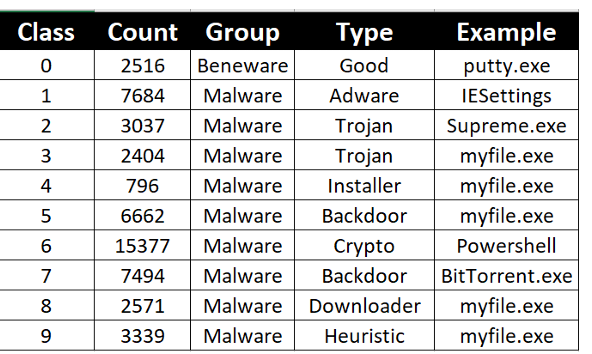

In [4]:
# Cargamos la base de datos.
dataset_path_train = 'virus_mnist/train'
dataset_path_test = 'virus_mnist/test'

# Cargamos las imágenes y etiquetas de entrenamiento.
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path_train,
    image_size=(28, 28),
    color_mode='grayscale',  # Escala de grises
    batch_size=32,  # Tamaño de los lotes
    label_mode='int'
)

# Cargamos las imágenes y etiquetas de prueba.
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path_test,
    image_size=(28, 28),
    color_mode='grayscale',
    batch_size=32,
    label_mode='int'
)

# Verificamos el conjunto de entrenamiento.
class_names = train_dataset.class_names
print(f'Clases en el conjunto de entrenamiento: {class_names}')

Found 48422 files belonging to 10 classes.
Found 3458 files belonging to 10 classes.
Clases en el conjunto de entrenamiento: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


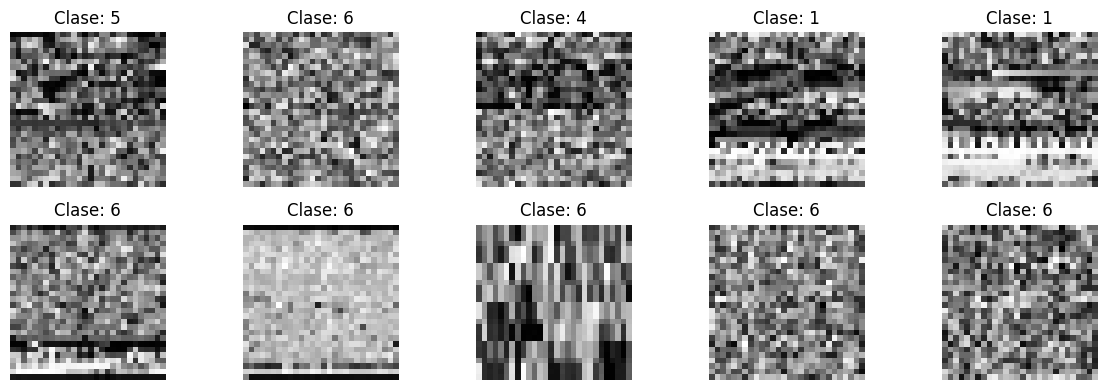

In [5]:
# Visualizamos algunas imágenes del conjunto de entrenamiento.
plt.figure(figsize=(12, 4))
for i, (image, label) in enumerate(train_dataset.take(1)):
    for j in range(10):
        plt.subplot(2, 5, j + 1)
        plt.imshow(image[j].numpy().astype('uint8'), cmap='gray')
        plt.title(f'Clase: {label[j].numpy()}')
        plt.axis('off')

plt.tight_layout()
plt.show()

In [20]:
def load_balanced_images(folder, img_size=(28, 28), max_per_class=380):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))

    for label, class_folder in enumerate(class_names):
        class_path = os.path.join(folder, class_folder)
        if os.path.isdir(class_path):
            count = 0
            for filename in os.listdir(class_path):
                if count >= max_per_class:
                    break
                img_path = os.path.join(class_path, filename)
                try:
                    img = Image.open(img_path).convert('L').resize(img_size)
                    images.append(np.array(img))
                    labels.append(label)
                    count += 1
                except:
                    continue
    return np.array(images), np.array(labels)

def aplicar_gaussiano(img, sigma=1.0):
    return gaussian_filter(img, sigma=sigma)

# Cargamos nuestros conjuntos.
X_train, y_train = load_balanced_images('virus_mnist/train', max_per_class=3500)
X_test, y_test = load_balanced_images('virus_mnist/test', max_per_class=3500)

X_train = np.array([aplicar_gaussiano(img) for img in X_train])
X_test = np.array([aplicar_gaussiano(img) for img in X_test])

# Normalizamos de forma que los valores de pixeles estén en el rango [0, 1].
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

# Expandimos la dimensión para canales (grises).
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [21]:
# Convertimos etiquetas a one-hot.
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [22]:
print("Forma de datos de entrenamiento: ", X_train.shape)
print("Forma de etiquetas de entrenamiento: ", y_train.shape)
print("Forma de datos de prueba: ", X_test.shape)
print("Forma de etiquetas de prueba: ", y_test.shape)

Forma de datos de entrenamiento:  (27651, 28, 28, 1)
Forma de etiquetas de entrenamiento:  (27651, 10)
Forma de datos de prueba:  (3458, 28, 28, 1)
Forma de etiquetas de prueba:  (3458, 10)


In [23]:
# Arquitectura de la convolucional.
model = keras.Sequential([
    ### Convolucional 1.
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),

    ## Capa de pooling.
    layers.MaxPooling2D(pool_size=(2, 2)),

    ## Convolusional 2, 64 filtros de 3x3, con ReLU.
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),

    ## Segunda capa de pooling.
    layers.MaxPooling2D(pool_size=(2, 2)),

    ## Aplanar los mapas de las características para la capa densa.
    layers.Flatten(),

    # Capa densa 128 neuronas.
    layers.Dense(128, activation='relu'),

    layers.Dropout(0.3), ## El Dropout regula y evita el overfitting.
    # Apaga el 30% de las neuronas durante el entrenamiento.

    # Capa de salida con 10 neuronas, una para cada dígito.
    layers.Dense(10, activation='softmax')
])
model.summary() # Resumen del modelo.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Compilamos el modelo.
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [25]:
# Aumentamos datos de la clase 0 (pues la cántidad de datos es mínima).
X_train_class0 = X_train[np.argmax(y_train, axis=1) == 0]
y_train_class0 = y_train[np.argmax(y_train, axis=1) == 0]

augment_size = X_train_class0.shape[0] * 3

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

flow = datagen.flow(X_train_class0, y_train_class0, batch_size=augment_size, shuffle=False)
X_augmented, y_augmented = next(flow)

X_train_balanced = np.concatenate([X_train, X_augmented])
y_train_balanced = np.concatenate([y_train, y_augmented])

In [26]:
## ENTRENAR EL MODELO
batch_size = 128 # Cada paso de entrenamiento usará 128 imágenes.
epochs = 12

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

y_train_labels = np.argmax(y_train, axis=1)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = dict(enumerate(class_weights))

history = model.fit(
    X_train_balanced, y_train_balanced,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    verbose=1)

Epoch 1/12
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.4638 - loss: 1.4458 - val_accuracy: 0.7380 - val_loss: 0.6881
Epoch 2/12
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7210 - loss: 0.6779 - val_accuracy: 0.7637 - val_loss: 0.6060
Epoch 3/12
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7633 - loss: 0.5729 - val_accuracy: 0.7921 - val_loss: 0.5226
Epoch 4/12
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7889 - loss: 0.5152 - val_accuracy: 0.7614 - val_loss: 0.6447
Epoch 5/12
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7999 - loss: 0.4793 - val_accuracy: 0.8389 - val_loss: 0.4247
Epoch 6/12
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8108 - loss: 0.4527 - val_accuracy: 0.8444 - val_loss: 0.4234
Epoch 7/12
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8162 - loss: 0.4386 - val_accuracy: 0.8704 - val_loss: 0.3983
Epoch 8/12
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8229 - loss: 0.4208 - val_accuracy: 0

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nPresición en el conjunto de prueba:, {test_acc:.4f}")


Presición en el conjunto de prueba:, 0.8702


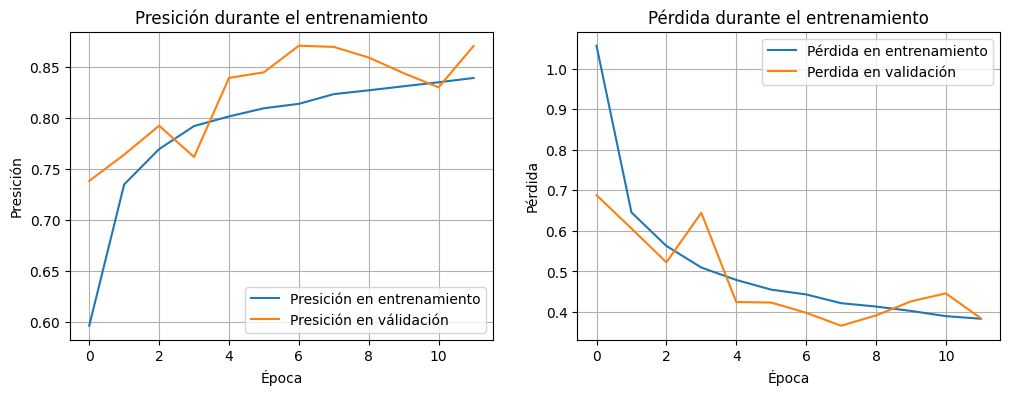

In [28]:
plt.figure(figsize=(12, 4)) ## Gráfica de presición durante el entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Presición en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Presición en válidación')
plt.title('Presición durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Presición')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2) ## Gráfica de pérdida durante entrenamiento
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Perdida en validación')
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


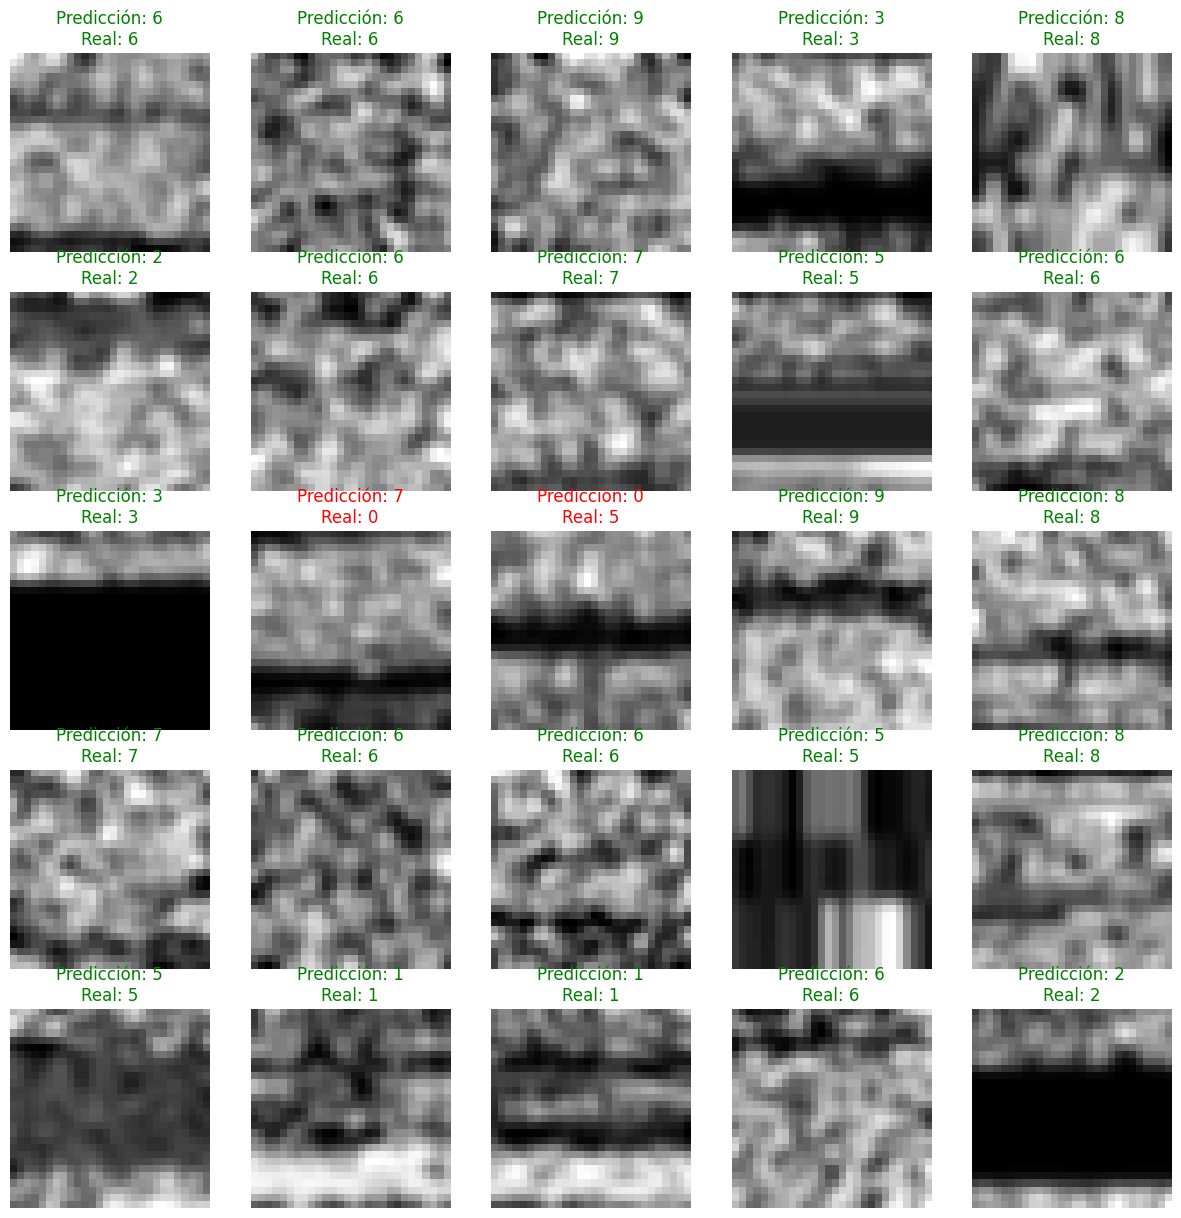

In [29]:
## Probamos el modelo ##
indices = np.arange(len(X_test))
np.random.shuffle(indices)
X_test_shuffled = X_test[indices]
y_test_shuffled = y_test[indices]

predictions = model.predict(X_test_shuffled)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test_shuffled, axis=1)

plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X_test_shuffled[i].squeeze(), cmap='gray')
    color='green' if predicted_labels[i] == true_labels[i] else 'red'
    plt.title(f"Predicción: {predicted_labels[i]}\nReal: {true_labels[i]}", color=color)
    plt.axis('off')
plt.show()


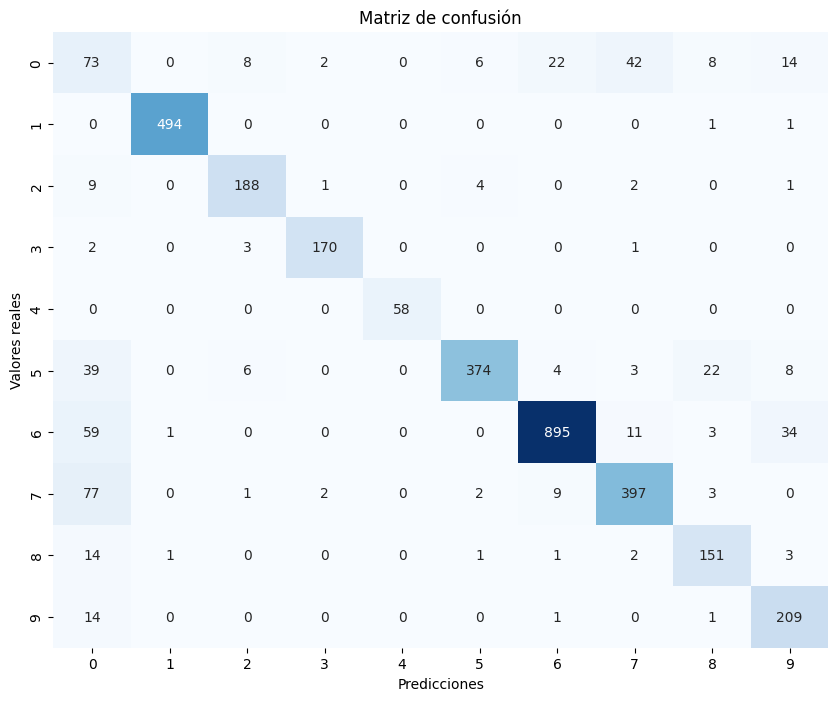

In [30]:
# Imprimimos matriz de confusión.
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()

In [31]:
# Imprimimos métricas de evaluación.
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.25      0.42      0.32       175
           1       1.00      1.00      1.00       496
           2       0.91      0.92      0.91       205
           3       0.97      0.97      0.97       176
           4       1.00      1.00      1.00        58
           5       0.97      0.82      0.89       456
           6       0.96      0.89      0.93      1003
           7       0.87      0.81      0.84       491
           8       0.80      0.87      0.83       173
           9       0.77      0.93      0.84       225

    accuracy                           0.87      3458
   macro avg       0.85      0.86      0.85      3458
weighted avg       0.90      0.87      0.88      3458

